# Project 02 - Due Friday, November 11 at 12pm

*Objectives*: Gain experience loading a transactional dataset into a relational database model you define yourself and using SQL to explore its contents. Transform the data into a star schema, documenting the schema visually, and explore the transformed data analytically by writing and executing a number of SQL queries using common syntax and functions and describing your findings.  Gain practice working on these tasks with a partner.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries, diagrams, and charts in the space provided, unless a text answer is requested.  The notebook itself should be completely reproducible at datanotebook.org, from start to finish: another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

*Attestation*: **Work in pairs**.  At the end of your submitted notebook, identify the work each partner performed and attest that each contributed substantially to the work.

*Deadline*: Friday, November 11, 12pm.  One member of each pair must submit your notebook to Blackboard; you should not both submit it separately.  You may each push a copy to your own GitHub repository.


## Setup - select and obtain data

The US City Open Data Census has a variety of [transactional data from all over the country](http://us-city.census.okfn.org/).  Select one topic and one city from this Census, download the data, and explain your reason for this choice before proceeding.  Provide a link to the web page for the data set you've chosen.

I strongly encourage you to select a dataset from among the following topics:  Crime, Property Assessment, Campaign Finance Contributions, Service Requests (311), and Web Analytics.

By *transactional* data I mean records at the grain of one event per business process.  In the case of Service Requests (311), for example, that would require data at the level of each individual report of a service request.  If this isn't clear, think about the bike trip data - each individual ride was included - and look for data at that level of event/process specificity.  Avoid data like the Connecticut boating data, which was summarized by year, not individual transactions.

Please aim for a dataset of at least 10,000 individual records, but less than 250,000 records.  A little more or a little less is okay, but try to stay within these limits.

#### We chose to use Austin Service Requests (311) data. Since the raw data set contains 370000+ records are are beyong the limits, we tried to use filter to limit the number of records at the source----since a majority of the service requests are received by phone and happened in Travis(Austin),we only want to explore service requests received by phone, belonging to transportation and pubilc works department in TRAVIS Austin.(https://data.austintexas.gov/Government/311-Unified-Data/i26j-ai4z)

In [1]:
!wget https://github.com/Yuanjing-Han/Yuanjing-Han-istm-6212/raw/master/Austin_request_data.zip

--2016-11-11 15:35:35--  https://github.com/Yuanjing-Han/Yuanjing-Han-istm-6212/raw/master/Austin_request_data.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Yuanjing-Han/Yuanjing-Han-istm-6212/master/Austin_request_data.zip [following]
--2016-11-11 15:35:35--  https://raw.githubusercontent.com/Yuanjing-Han/Yuanjing-Han-istm-6212/master/Austin_request_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6369721 (6.1M) [application/octet-stream]
Saving to: ‘Austin_request_data.zip’

Austin_request_data 100%[=====================>]   6.07M  --.-KB/s   in 0.1s   

2016-11-11 15:35:35 (43.3 MB/s) - ‘Austin_requ

In [2]:
!unzip Austin_request_data.zip

Archive:  Austin_request_data.zip
  inflating: 311_Unified_Data.csv    


In [3]:
!mv 311_Unified_Data.csv servicerequest.csv

In [4]:
!csvcut -n servicerequest.csv

  1: Service Request (SR) Number
  2: SR Type Code
  3: SR Description
  4: Owning Department
  5: Method Received
  6: SR Status
  7: Status Change Date
  8: Created Date
  9: Last Update Date
 10: Close Date
 11: SR Location
 12: Street Number
 13: Street Name
 14: City
 15: Zip Code
 16: County
 17: State Plane X Coordinate
 18: State Plane Y Coordinate
 19: Latitude Coordinate
 20: Longitude Coordinate
 21: (Latitude.Longitude)
 22: Council District
 23: Map Page
 24: Map Tile


In [5]:
!wc -l servicerequest.csv

84579 servicerequest.csv


In [6]:
!head -1 servicerequest.csv | csvlook

|------------------------------+--------------+----------------+-------------------+-----------------+-----------+--------------------+--------------+------------------+------------+-------------+---------------+-------------+------+----------+--------+--------------------------+--------------------------+---------------------+----------------------+----------------------+------------------+----------+-----------|
|  Service Request (SR) Number | SR Type Code | SR Description | Owning Department | Method Received | SR Status | Status Change Date | Created Date | Last Update Date | Close Date | SR Location | Street Number | Street Name | City | Zip Code | County | State Plane X Coordinate | State Plane Y Coordinate | Latitude Coordinate | Longitude Coordinate | (Latitude.Longitude) | Council District | Map Page | Map Tile  |
|------------------------------+--------------+----------------+-------------------+-----------------+-----------+--------------------+--------------+--------------

In [7]:
!echo 'redspot' | sudo -S service postgresql restart

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


In [8]:
!createdb -U dbuser servicerequest311

In [9]:
%load_ext sql

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [10]:
%sql postgresql://dbuser@localhost:5432/servicerequest311

'Connected: dbuser@servicerequest311'

## Problem 1 - examine the data (20 points)

Use `csvstat`, `pandas`, or other tools as you see fit and observe the contents of your dataset.  Review important points from any metadata provided.  Describe what you see:  What do the columns mean?  Are there null values?  Which columns interest you the most?  Which columns present some opportunities, challenges, or questions you would like to ask?

# Variables explaining
* Service Request (SR) Number: The service request tracking number.
* SR Type Code: The logogram of each type of service request.
* SR Description: Service request type.
* Owning Department: Owning department of SR type.
* Method Received: Contact method SR was received from. Mass entry requests are submitted by dept. in groups after work is         completed.
* SR Status: SR status. Duplicate statuses indicate that issue had previously been reported recently.
* Status Change Date: Date of last SR status change. Status changes occur when SR moves from one status to another. I.E. new to   open, open to closed.
* Created Date: Date SR was created.
* Last Update Date: Date SR was updated. Last date SR received updates. Updates may include creation, status changes, or changes   to data in SR.
* Close Date: Date SR was closed, with null value.
* SR Location: Service location of SR.
* Street Number: Parsed location information. Street number. with null value.
* Street Name: Parsed location information, with null value.
* City: Parsed location information---AUSTIN.
* Zip Code：Parsed location information, with null value.
* County：Parsed location information---TRAVIS.
* State Plane X Coordinate：State plane X coordinate, with null value.
* State Plane Y Coordinate：State plane Y coordinate, with null value.
* Latitude Coordinate: SR location latitude coordinate, with null value.
* Longitude Coordinate: SR location latitude and longitude coordinates,with null value.
* (Latitude.Longitude):SR location latitude and longitude coordinates, with null value.
* Council District: Council district corresponding to SR location. Locations outside of the City of Austin jurisdiction will not   have a council district, with null value.
* Map Page: SR location corresponding map page, with null value.
* Map Title: SR location corresponding map tile, with null value.


Since this database is related with service requests, we are really interested how many service requests actually happened in the certain time period, in the certain region and of a certain type. Thus,the following columns present some opportunities,challenges or questions that I want to ask: Service Request (SR) Number, SR Type Code, SR Description,Created Date,street address,Zip Code,Council District.



#### The question we wanna ask is that in which part of Travis does service requests happen the most actively? I found that in the east end of county, the plots are denser. Thus we think that in east end of Travis,service requests happen more actively.

In [11]:
import pandas as pd
df_request = pd.read_csv('servicerequest.csv',parse_dates=['Status Change Date','Created Date','Last Update Date','Close Date'],error_bad_lines=False)

In [12]:
df_request.head(5)

,Service Request (SR) Number,SR Type Code,SR Description,Owning Department,Method Received,SR Status,Status Change Date,Created Date,Last Update Date,Close Date,...,Zip Code,County,State Plane X Coordinate,State Plane Y Coordinate,Latitude Coordinate,Longitude Coordinate,(Latitude.Longitude),Council District,Map Page,Map Tile
0,16-00107769,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),2016-05-06 12:11:57,2016-05-06 12:01:46,2016-05-06 12:11:57,2016-05-06 12:11:57,...,78703.0,TRAVIS,3.106038e+06,1.008098e+07,30.296699,-97.768264,"(30.29669887, -97.76826374)",10.0,584C,MH24
1,16-00108244,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),2016-05-06 19:51:27,2016-05-06 19:51:27,2016-05-06 19:51:27,2016-05-06 19:51:27,...,78745.0,TRAVIS,3.096240e+06,1.005019e+07,30.212695,-97.801521,"(30.2126949, -97.8015215)",5.0,643M,MF17
2,16-00108269,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),2016-05-06 20:22:56,2016-05-06 20:22:56,2016-05-06 20:22:56,2016-05-06 20:22:56,...,78745.0,TRAVIS,3.096240e+06,1.005019e+07,30.212695,-97.801521,"(30.2126949, -97.8015215)",5.0,643M,MF17
3,16-00108062,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),2016-05-10 16:56:52,2016-05-06 17:03:45,2016-05-10 16:56:52,2016-05-10 16:56:52,...,78759.0,TRAVIS,3.105863e+06,1.011309e+07,30.384989,-97.766471,"(30.38498865, -97.76647071)",10.0,494L,MH32
4,16-00107570,TRAFFI10,Traffic Signal - Dig Tess Request,Transportation,Phone,Closed,2016-05-06 09:42:06,2016-05-06 09:30:00,2016-05-06 09:42:06,2016-05-06 09:42:06,...,78722.0,TRAVIS,3.120409e+06,1.007505e+07,30.279474,-97.723184,"(30.27947367, -97.72318365)",1.0,585Q,MK23


In [13]:
import numpy as np
x = df_request['Latitude Coordinate'].values
y = df_request['Longitude Coordinate'].values
X = x.reshape(len(x),1)
Y = y.reshape(len(y),1)
mydata = np.hstack((X,Y))

In [14]:
myData = mydata[~np.isnan(mydata).any(axis=1)]

In [15]:
print(myData)

[[ 30.29669887 -97.76826374]
 [ 30.2126949  -97.8015215 ]
 [ 30.2126949  -97.8015215 ]
 ..., 
 [ 30.26832189 -97.7364928 ]
 [ 30.26808964 -97.75173887]
 [ 30.19577459 -97.77327825]]


In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(myData)

In [18]:
kmeans.labels_

array([2, 1, 1, ..., 2, 2, 1], dtype=int32)

In [19]:
import matplotlib.pyplot as pp

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


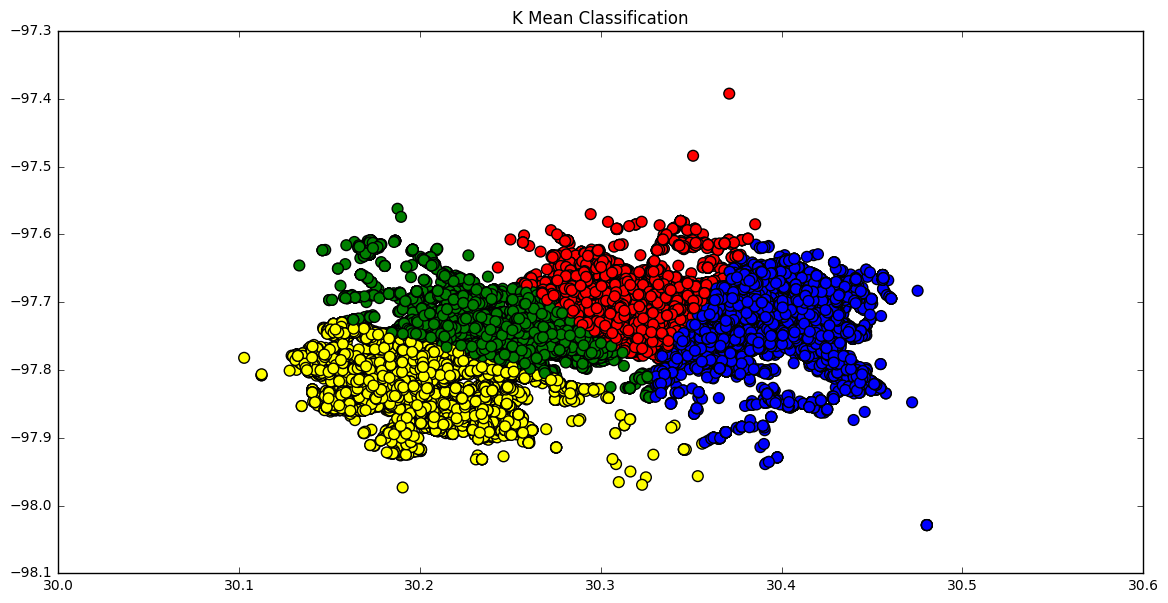

In [20]:
# View the results
# Set the size of the plot
pp.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'yellow','green','blue'])
 
# Plot the Models Classifications
#pp.subplot(1, 1, 1)
pp.scatter(myData[:,0], myData[:,1], c=colormap[kmeans.labels_], s=60)
pp.title('K Mean Classification')


In [21]:
pp.show()

In [22]:
df_request.isnull().sum()

Service Request (SR) Number        0
SR Type Code                       0
SR Description                     0
Owning Department                  0
Method Received                    0
SR Status                          0
Status Change Date                 0
Created Date                       0
Last Update Date                   0
Close Date                      4142
SR Location                        0
Street Number                  44117
Street Name                       17
City                               0
Zip Code                           1
County                             0
State Plane X Coordinate           1
State Plane Y Coordinate          16
Latitude Coordinate                3
Longitude Coordinate               3
(Latitude.Longitude)               3
Council District                1144
Map Page                           1
Map Tile                           2
dtype: int64

In [ ]:
!csvstat servicerequest.csv

## Problem 2 - define a database model, load the data, and explore (20 points)

Based on what you found above, create and connect to a new database, define a database table in it, and load this dataset into it.  You may use either of the methods for this step you have seen in earlier class notebooks.  You may choose to eliminate variables/columns if they are not relevant or interesting to you - explain your reasoning if you do.  Either way, you should load a majority of the columns present in the source dataset as it is in its raw form into the database, and all of its rows.

Once your data has loaded successfully, run a `COUNT(*)` query to verify that all the data has loaded correctly.

Explore the data to zero in on a few themes you would like to further study analytically.  Discuss columns that present opportunities for extraction into dimensions, and identify the specific columns that contain facts you want to measure.

#### In this step, we create and connecte to a new database, and define it as sr_austin. We load all data from the data source into sr_austin. We explore columns of this new database. For instance, what is the lastest date of created_date? How many records do we have? How many types of requests about this database? For Public Works department, what is the frequency of each type of requests?  How many types of status? How many requests happened in each council_district?

In [24]:
%%sql
DROP TABLE IF EXISTS sr_austin;
CREATE TABLE sr_austin (
    SR_number VARCHAR(11),
    SR_type_code VARCHAR(8),
    SR_description VARCHAR(51),
    Owning_department VARCHAR(44),
    Method_received VARCHAR(18),
    SR_Status VARCHAR(30),
    Status_change_date TIMESTAMP,
    Created_date TIMESTAMP,
    Last_update_date TIMESTAMP,
    Close_date TIMESTAMP,
    SR_location VARCHAR(151),
    Street_number INTEGER,
    Street_name VARCHAR(76),
    City VARCHAR(16),
    Zip_code INTEGER,
    County VARCHAR(25),
    State_Plane_X_Coordinate VARCHAR(300), 
    State_Plane_Y_Coordinate VARCHAR(300),
    Latitude_Coordinate VARCHAR(80),
    Longitude_Coordinate VARCHAR(80),
    Latitude_Longitude POINT,
    Council_District INTEGER,
    Map_Page VARCHAR(4),
    Map_Tile VARCHAR(4)
);

Done.
Done.


[]

In [25]:
!pwd

/home/jovyan/work


In [26]:
%%sql
COPY sr_austin FROM '/home/jovyan/work/servicerequest.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ','; 

84578 rows affected.


[]

In [27]:
%%sql
SELECT *
FROM sr_austin
LIMIT 1;

1 rows affected.


sr_number,sr_type_code,sr_description,owning_department,method_received,sr_status,status_change_date,created_date,last_update_date,close_date,sr_location,street_number,street_name,city,zip_code,county,state_plane_x_coordinate,state_plane_y_coordinate,latitude_coordinate,longitude_coordinate,latitude_longitude,council_district,map_page,map_tile
16-00107769,TRASIGMA,Traffic Signal - Maintenance,Transportation,Phone,Duplicate (closed),2016-05-06 12:11:57,2016-05-06 12:01:46,2016-05-06 12:11:57,2016-05-06 12:11:57,"WINDSOR RD & EXPOSITION BLVD, AUSTIN, TX 78703",None,WINDSOR RD & EXPOSITION BLVD,AUSTIN,78703,TRAVIS,3106038.49745799,10080978.0030157,30.29669887,-97.76826374,"(30.29669887,-97.76826374)",10,584C,MH24


In [28]:
%%sql
SELECT MAX(Created_date)
FROM sr_austin;

1 rows affected.


max
2016-11-04 10:26:07


In [29]:
%%sql 
SELECT MIN(Created_date)
FROM sr_austin;

1 rows affected.


min
2014-01-01 04:25:00


#### The number of service requests can be measured in a certain time period, thus created time and the more specific information extracted from it could become a dimension. 

In [30]:
%%sql
SELECT COUNT(*)
FROM sr_austin;

1 rows affected.


count
84578


In [31]:
%%sql
SELECT sr_description,COUNT(*) AS num_sr
FROM sr_austin
WHERE owning_department = 'Transportation'
GROUP BY sr_description
ORDER BY num_sr DESC;

35 rows affected.


sr_description,num_sr
Traffic Signal - Maintenance,21554
Traffic Signal - Dig Tess Request,8304
Sign - Traffic Sign Emergency,2916
Parking Machine Issue,2519
Sign - New,2445
Concerns in the ROW,2098
View Obstruction at Intersection,1984
Sign - Traffic Sign Maintenance,1889
Sign - Street Name,1322
Road Markings/Striping - Maintenance,1299


#### We want to know of the service requests, how many of them are of a centain type, thus type of service request could be a dimension.

In [32]:
%%sql
SELECT sr_description,COUNT(*) AS num_sr
FROM sr_austin
WHERE owning_department = 'Public Works'
GROUP BY sr_description
ORDER BY num_sr DESC;

24 rows affected.


sr_description,num_sr
Debris in Street,4822
Obstruction in ROW,4601
Pothole Repair,4044
Tree Issue ROW/Maintenance (PW),3652
Tree Issue ROW/Emergency (PW),3462
Pavement Failure,2312
Sidewalk Repair,1597
Mowing Medians,1389
Alley & Unpaved Street Maintenance,968
Curb/Gutter Repair,439


#### We want to know how many service requests happened in a certain region, thus location information such as council district,zip code street address could be a dimension.

In [33]:
%%sql
SELECT Council_District,COUNT(*) AS sr_num
FROM sr_austin
GROUP BY Council_District
ORDER BY sr_num DESC;

11 rows affected.


council_district,sr_num
9,18114
7,9695
1,9636
10,9249
3,8386
5,8286
2,6307
8,6075
4,6001
6,1685


## Problem 3 - define a star schema, and load your data into it (30 points)

Define a star schema consisting of at least one fact table and at least two dimensions.  Transform your source data into the new fact table and dimensions.  Discuss your key modeling decisions.

Document your star schema with a diagram.  There several tools available for this, such as Google Docs and Microsoft Visio.

#### In this step, we define three dimension tables and one fact table. About dimension tables, we respectively create time table, loaction table and type table. We creat one fact table which includes sr_number, time_key, address_key and sr_type key. We think time, location and type can help us measure the frequency of requests. Thus we use these three dimension to create the factless fact table for events, which contains every single record of service request. It seems that facts are associated with a service requests process and it does support measurement. We can explore more detailed things by joining dimension tables with fact table. 

### Step 1. In this step, we select columns from source data which we want to explore and create a table named sr

In [37]:
%%sql
DROP TABLE IF EXISTS sr;
CREATE TABLE sr(
    sr_number VARCHAR(11),
    code VARCHAR(8),
    description VARCHAR(51),
    created_date TIMESTAMP,
    address VARCHAR(151),
    zip_code INTEGER,
    CouncilDistrict INTEGER
);

Done.
Done.


[]

In [38]:
%%sql
INSERT INTO sr(sr_number,code,description,created_date,address,zip_code,CouncilDistrict)
SELECT DISTINCT SR_number,SR_type_code,SR_description,Created_date,SR_location,Zip_code,Council_District
FROM sr_austin;

84578 rows affected.


[]

### Step 2. We deal with some special columns which includes null value.

In [39]:
%%sql
UPDATE sr
SET zip_code = 0
WHERE zip_code IS NULL;

1 rows affected.


[]

In [40]:
%%sql
UPDATE sr
SET CouncilDistrict = 9999
WHERE CouncilDistrict IS NULL;

1144 rows affected.


[]

### Step 3. We create the dimension table time, the dimension table location, and the dimension table type.

In [41]:
%%sql
DROP TABLE IF EXISTS time;
CREATE TABLE time(
    day_key SERIAL,
    created_date TIMESTAMP,
    day_of_year CHAR(10),
    year INTEGER,
    month INTEGER,
    day INTEGER,
    day_of_week_str CHAR(9),
    quarter INTEGER,
    CONSTRAINT pk_day_key PRIMARY KEY(day_key)
);

Done.
Done.


[]

In [42]:
%%sql
INSERT INTO time(created_date,day_of_year,year,month,day,day_of_week_str,quarter)
SELECT DISTINCT created_date,
    TO_CHAR(created_date, 'YYYY-MM-DD') AS day_of_year,
    CAST(TO_CHAR(created_date, 'YYYY') AS INTEGER) AS year,
    CAST(TO_CHAR(created_date, 'MM') AS INTEGER) AS month,
    CAST(TO_CHAR(created_date, 'DD') AS INTEGER) AS day,
    TO_CHAR(created_date, 'Day') AS day_of_week_str,
    CAST(TO_CHAR(created_date, 'Q') AS INTEGER) AS quarter
FROM sr;

84329 rows affected.


[]

In [43]:
%%sql
DROP TABLE IF EXISTS location;
CREATE TABLE location(
    address_key SERIAL,
    streetaddress VARCHAR(151),
    zipcode INTEGER,
    councildistrict INTEGER,
    CONSTRAINT pk_address_key PRIMARY KEY(address_key)
);

Done.
Done.


[]

In [44]:
%%sql
INSERT INTO location(streetaddress,zipcode,councildistrict)
SELECT DISTINCT address,zip_code,CouncilDistrict
FROM sr;

43106 rows affected.


[]

In [45]:
%%sql
DROP TABLE IF EXISTS sr_type;
CREATE TABLE sr_type(
    type_key SERIAL,
    sr_code VARCHAR(8),
    sr_description VARCHAR(51),
    CONSTRAINT pk_type_key PRIMARY KEY(type_key)
);

Done.
Done.


[]

In [46]:
%%sql
INSERT INTO sr_type(sr_code,sr_description)
SELECT DISTINCT code,description
FROM sr;

56 rows affected.


[]

### we create a table days, which is used later for joining with sr. 

In [47]:
%%sql 
DROP TABLE IF EXISTS days;
CREATE TABLE days(
    srnumber VARCHAR(11),
    created_date TIMESTAMP,
    day_of_year CHAR(10),
    year INTEGER,
    month INTEGER,
    day INTEGER,
    day_of_week_str CHAR(9),
    quarter INTEGER
);

Done.
Done.


[]

In [48]:
%%sql
INSERT INTO days(srnumber,created_date,day_of_year,year,month,day,day_of_week_str,quarter)
SELECT DISTINCT sr_number,created_date,
    TO_CHAR(created_date, 'YYYY-MM-DD') AS day_of_year,
    CAST(TO_CHAR(created_date, 'YYYY') AS INTEGER) AS year,
    CAST(TO_CHAR(created_date, 'MM') AS INTEGER) AS month,
    CAST(TO_CHAR(created_date, 'DD') AS INTEGER) AS day,
    TO_CHAR(created_date, 'Day') AS day_of_week_str,
    CAST(TO_CHAR(created_date, 'Q') AS INTEGER) AS quarter
FROM sr;

84578 rows affected.


[]

### Step 4. We join days with sr to load data into this initial fact table model and create foreign key references pointing to the primary keys in the dimension table which create the connection between the fact table and the dimension table. 

In [50]:
%%sql
DROP TABLE IF EXISTS sr_fact;
CREATE TABLE sr_fact(
    sr_number VARCHAR(11),
    type_key INTEGER,
    date_key INTEGER,
    address_key INTEGER,
    code VARCHAR(8),
    description VARCHAR(51),
    address VARCHAR(151),
    zip_code INTEGER,
    CouncilDistrict INTEGER,
    created_date TIMESTAMP,
    day_of_year CHAR(10),
    year INTEGER,
    month INTEGER,
    day INTEGER,
    day_of_week_str CHAR(9),
    quarter INTEGER,
    FOREIGN KEY(type_key) REFERENCES sr_type(type_key),
    FOREIGN KEY(address_key) REFERENCES location(address_key),
    FOREIGN KEY(date_key) REFERENCES time(day_key)
);

Done.
Done.


[]

In [51]:
%%sql
INSERT INTO sr_fact(sr_number,code,description,created_date,address,zip_code,CouncilDistrict,day_of_year,year,
                   month,day,day_of_week_str,quarter)
SELECT DISTINCT sr.sr_number,
code,
description,
sr.created_date,
address,
zip_code,
CouncilDistrict,
day_of_year,
year,
month,
day,
day_of_week_str,
quarter
FROM sr
INNER JOIN days on sr.sr_number = days.srnumber;

84578 rows affected.


[]

### We insert three primary keys from three dimension tables as our foreign key in the fact table

In [52]:
%%sql
UPDATE sr_fact
SET type_key = sr_type.type_key
FROM sr_type
WHERE sr_fact.code = sr_type.sr_code AND sr_fact.description = sr_type.sr_description;

84578 rows affected.


[]

In [53]:
%%sql
UPDATE sr_fact
SET date_key = time.day_key
FROM time
WHERE sr_fact.created_date = time.created_date;

84578 rows affected.


[]

In [54]:
%%sql
UPDATE sr_fact
SET address_key = location.address_key
FROM location
WHERE sr_fact.address = location.streetaddress AND sr_fact.zip_code = location.zipcode 
      AND sr_fact.CouncilDistrict = location.councildistrict;

84578 rows affected.


[]

In [55]:
%%sql
SELECT *
FROM sr_fact
LIMIT 2;

2 rows affected.


sr_number,type_key,date_key,address_key,code,description,address,zip_code,councildistrict,created_date,day_of_year,year,month,day,day_of_week_str,quarter
14-00104671,4,61236,102,SIGNNEWT,Sign - New,"6609 FELIX AVE, AUSTIN, TX",78741,3,2014-05-31 12:30:02,2014-05-31,2014,5,31,Saturday,2
14-00112947,9,58588,36047,MOWINGME,Mowing Medians,"900 REDD ST, AUSTIN, TX",78745,5,2014-06-10 07:55:39,2014-06-10,2014,6,10,Tuesday,2


### We delete some columns which we  will not explore in following steps.

In [56]:
%%sql
ALTER TABLE sr_fact
DROP COLUMN code;
ALTER TABLE sr_fact
DROP COLUMN description;
ALTER TABLE sr_fact
DROP COLUMN address;
ALTER TABLE sr_fact
DROP COLUMN zip_code;
ALTER TABLE sr_fact
DROP COLUMN CouncilDistrict;
ALTER TABLE sr_fact
DROP COLUMN day_of_year;
ALTER TABLE sr_fact
DROP COLUMN year;
ALTER TABLE sr_fact
DROP COLUMN month;
ALTER TABLE sr_fact
DROP COLUMN day;
ALTER TABLE sr_fact
DROP COLUMN day_of_week_str;
ALTER TABLE sr_fact
DROP COLUMN quarter;
ALTER TABLE sr_fact
DROP COLUMN created_date;

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [57]:
%%sql
SELECT *
FROM sr_fact
LIMIT 3;

3 rows affected.


sr_number,type_key,date_key,address_key
14-00112947,9,58588,36047
14-00146359,4,60823,34816
14-00185357,4,67196,4326


### Below is the star schema diagram, it shows the relationship between fact table and dimension tables.

In [58]:
from IPython.display import Image
Image(url="https://github.com/Yuanjing-Han/Yuanjing-Han-istm-6212/raw/master/Star%20Schema_diagram.jpg")

## Problem 4 - explore your data in its new schema (30 points)

Strictly using the dimensional model tables you defined and populated for Problem 3, explore your data in its new form.  Use any of the query strategies we've seen in class, including transformations, aggregates, subqueries, rollups, and, of course, joins.  Add plots to highlight particular themes that stand out.  Describe your thinking and observations along the way.

### Question 1. We want to know how many service requests actually happened in the first quarter of 2014?

In [60]:
%%sql
SELECT COUNT(*) AS num_sr
FROM (SELECT day_of_year,quarter,sr_number
      FROM sr_fact
      LEFT JOIN time ON sr_fact.date_key = time.day_key) AS d
WHERE day_of_year LIKE '2014%' AND quarter = 1;

1 rows affected.


num_sr
5947


### Question2. We want to know how many service requests actually happened in all Tuesdays of the second quarter in 2015?

In [62]:
%%sql
SELECT COUNT(*) AS num_sr
FROM (SELECT day_of_year,quarter,day_of_week_str,sr_number
      FROM sr_fact
      LEFT JOIN time ON sr_fact.date_key = time.day_key) AS d
WHERE day_of_year LIKE '2015%' AND quarter = 2 AND day_of_week_str = 'Tuesday';

1 rows affected.


num_sr
1778


### Question 3. We want to konw which are the top 5 zipcode where service requests occured the most frequently in the third quarter of 2016 and what is the number of service requests in those top5 zipcode?

In [63]:
%%sql
SELECT zipcode,COUNT(*)
FROM(
    SELECT day_of_year,quarter,zipcode,sr_number
    FROM sr_fact
    LEFT JOIN time ON sr_fact.date_key = time.day_key
    LEFT JOIN location ON sr_fact.address_key = location.address_key) AS d
WHERE day_of_year LIKE '2016%' AND quarter = 3
GROUP BY zipcode
ORDER BY COUNT(*)DESC
LIMIT 5;

5 rows affected.


zipcode,count
78704,686
78745,626
78701,510
78744,422
78702,385


<Container object of 5 artists>

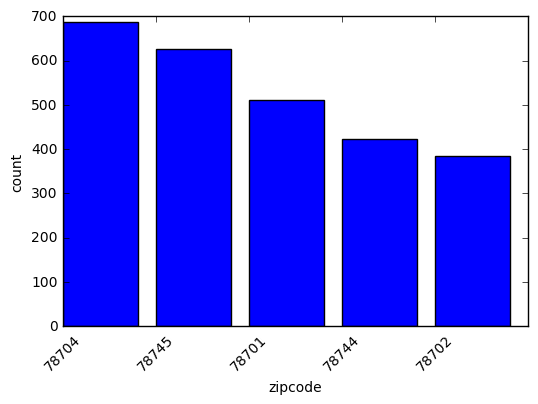

In [64]:
%matplotlib inline
result = _
result.bar()

Similarly, we want to konw which are the top 5 council districts where service requests occured the most frequently in the third quarter of 2016 and what is the number of service requests in those top5 council districts?

In [65]:
%%sql
SELECT councildistrict,COUNT(*)
FROM(
    SELECT day_of_year,quarter,councildistrict,sr_number
    FROM sr_fact
    LEFT JOIN time ON sr_fact.date_key = time.day_key
    LEFT JOIN location ON sr_fact.address_key = location.address_key) AS d
WHERE day_of_year LIKE '2015%' AND quarter = 4
GROUP BY councildistrict
ORDER BY COUNT(*)DESC
LIMIT 5;

5 rows affected.


councildistrict,count
9,1454
10,816
1,746
3,702
7,661


<Container object of 5 artists>

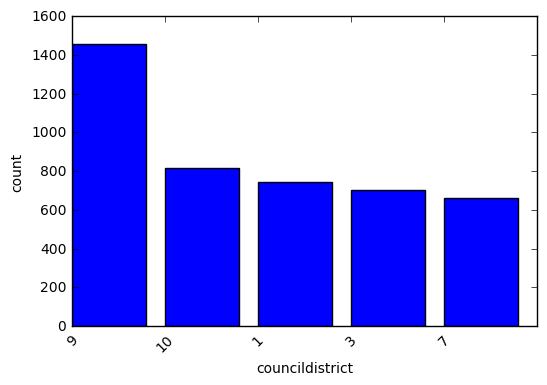

In [66]:
%matplotlib inline
result = _
result.bar()

### Question 4. We want to know in the third quarter of 2014, in each zipcode, which type of service requests happened the most frequently? It seems that in each single zip code, service request concerning Traffic signal maintenance happened the most frequently.

In [68]:
%%sql
SELECT DISTINCT zipcode,sr_description,COUNT(*)
FROM(
    SELECT day_of_year,quarter,zipcode,sr_description,sr_number
    FROM sr_fact
    LEFT JOIN time ON sr_fact.date_key = time.day_key
    LEFT JOIN location ON sr_fact.address_key = location.address_key
    LEFT JOIN sr_type ON sr_fact.type_key = sr_type.type_key) AS d
WHERE day_of_year LIKE '2014%' AND quarter = 3 
GROUP BY zipcode,sr_description
ORDER BY COUNT(*)DESC
LIMIT 10;

10 rows affected.


zipcode,sr_description,count
78759,Traffic Signal - Maintenance,225
78701,Parking Machine Issue,170
78758,Traffic Signal - Maintenance,147
78749,Traffic Signal - Maintenance,130
78723,Traffic Signal - Maintenance,108
78757,Traffic Signal - Maintenance,106
78744,Traffic Signal - Maintenance,105
78704,Traffic Signal - Maintenance,105
78703,Traffic Signal - Maintenance,98
78741,Traffic Signal - Maintenance,96


Since our data contain service requests from the beginning of 2014 to the end of 2016, we want to know in each three identical quarter of these three years, in a centain zip code, what type of service requests happened and there are how many of them? 

In [70]:
%%sql
SELECT quarter,zipcode,sr_description,COUNT(*)
FROM(
    SELECT quarter,zipcode,sr_description,sr_number
    FROM sr_fact
    LEFT JOIN time ON sr_fact.date_key = time.day_key
    LEFT JOIN location ON sr_fact.address_key = location.address_key
    LEFT JOIN sr_type ON sr_fact.type_key = sr_type.type_key) AS d
GROUP BY ROLLUP(quarter,zipcode,sr_description)
LIMIT 10;

10 rows affected.


quarter,zipcode,sr_description,count
1,78617,Concerns in the ROW,2
1,78617,Debris in Street,1
1,78617,Guardrail Repair,5
1,78617,Pavement Failure,2
1,78617,Pothole Repair,6
1,78617,Road Markings/Striping - Maintenance,1
1,78617,Road Markings/Striping - New,1
1,78617,Road Sanding Request,1
1,78617,School Zone - New/Review/Changes,2
1,78617,School Zone Flasher - Timing/Maintenance,3


### Question 5. We want to know in the year of 2016, what is the top 10 types of service request in Travis, Austin?

In [72]:
%%sql
SELECT sr_description, COUNT(*)
FROM(
    SELECT day_of_year,month,quarter,sr_description,sr_number
    FROM sr_fact
    LEFT JOIN time ON sr_fact.date_key = time.day_key
    LEFT JOIN sr_type ON sr_fact.type_key = sr_type.type_key) AS d
WHERE day_of_year LIKE '2016%' 
GROUP BY sr_description
ORDER BY COUNT(*) DESC
LIMIT 10;

10 rows affected.


sr_description,count
Traffic Signal - Maintenance,5680
Tree Issue ROW/Maintenance (PW),1791
Debris in Street,1612
Tree Issue ROW/Emergency (PW),1573
Obstruction in ROW,1350
Pothole Repair,1183
Traffic Signal - Dig Tess Request,1015
Mowing Medians,800
View Obstruction at Intersection,793
Parking Machine Issue,775


### Question6. We want to know in the year of 2015, which councils have higher than average frequencies of service requests?

In [73]:
%%sql
SELECT councildistrict, COUNT(*) 
FROM (SELECT day_of_year, councildistrict, sr_number
     FROM sr_fact
     LEFT JOIN time ON sr_fact.date_key = time.day_key
     LEFT JOIN location ON sr_fact.address_key = location.address_key) AS g
WHERE day_of_year LIKE '2015%'
GROUP BY councildistrict 
ORDER BY COUNT(*) DESC;

11 rows affected.


councildistrict,count
9,6832
1,3793
7,3583
10,3439
5,3207
3,3147
2,2547
4,2324
8,2275
6,560


In [74]:
%%sql
DROP TABLE IF EXISTS councildistrict_frequency;
CREATE TABLE councildistrict_frequency(
    CouncilDistrict INTEGER,
    number_of_request INTEGER
);

Done.
Done.


[]

In [75]:
%%sql
INSERT INTO councildistrict_frequency(CouncilDistrict,number_of_request)
SELECT DISTINCT councildistrict, COUNT(*) 
FROM (SELECT day_of_year, councildistrict, sr_number
     FROM sr_fact
     LEFT JOIN time ON sr_fact.date_key = time.day_key
     LEFT JOIN location ON sr_fact.address_key = location.address_key) AS g
WHERE day_of_year LIKE '2015%'
GROUP BY councildistrict 
ORDER BY COUNT(*) DESC;

11 rows affected.


[]

In [76]:
%%sql
SELECT * 
FROM councildistrict_frequency
WHERE 
    number_of_request > (SELECT AVG(number_of_request) FROM councildistrict_frequency);

6 rows affected.


councildistrict,number_of_request
9,6832
1,3793
7,3583
10,3439
5,3207
3,3147


## Bonus (10 points for one of A or B)


### Option A - Automating ETL

Consider the work you did to load your original raw dataset and then transform it into a dimensional model for analysis.  What would it take to automate this process?  How often would you need to update the data?  Could you easily automate any data cleaning steps?  What checks would you need to put in place to ensure quality?  Would humans need to be involved, or could you automate it all?

Discuss.


### Option B - Augmenting dimensions

Considering your dimensional model, what external data could you find to augment it?  As in the case of bike trips, where weather might provide an interesting added dimension/context not present in the original data, you can probably find another source of data to complement your own model.  Identify one such source and add it to your model, demonstrating its value with a few new queries.

## Option A
#### What would it take to automate this process?
To automate this process, firstly, we need to supplement the existing tables in the database with the data obtained from outside your organization. The data may be commercially available datasets or data from less structured sources such as social media or more. Secondly, you will need to cleanse, validate and transform the data before loading it into an existing database. Thirdly, Extract, transform and load(ETL) operations can perform data categorization, de-duplication, matching and summary operations on unstructured or semi-structured data to generate data in familiar rows and columns that can be imported into a database table or a data warehouse.

#### How often would you need to update the data? 
When new data coming in or the existing records changing, it’s time to update the data but that is not practical since you can’t update that frequently if data continue changing or coming in. I think the most reasonable updating frequency would be one time per day.

#### Could you easily automate any data cleaning steps?
I think generally I could. The data cleaning process seems rather fixed and we can apply the existing postgreSQL code to new data in the column. We have NULL values in several columns, such as zip code, council district and close date---they are of different data types, but we could use the stored code to automate the data cleaning process.

#### What checks would you need to put in place to ensure quality? 
In my case with the service request datasets, I checked if service request number is the unique identifier of the whole dataset and fortunately the answer is yes which means that every record is unique and there are no duplicates concerning each service request record and our dataset is quite neat although we have many missing values. With that unique identifier, we can do ETL operations such as JOIN, COUNT etc more easily.  

#### Would humans need to be involved, or could you automate it all?
I thing in our case humans would not need to be involved in automating process since we have unique identifier---service request number and we could apply our stored SQL code to deal with all columns of data associated with their data types.


## Completed by Yuanjing Han and Youdan Shi.We collaborate with each other to finish all the code and markdown. We're both satisfied with the contribution of each other.